In [161]:
import numpy as np
import pandas as pd
import math
import sys, os
#import seaborn as sns
#from scipy import stats
#from pathlib import Path
#import matplotlib.pyplot as plt
#from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.datasets import fetch_california_housing
#import math
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import optuna
from optuna.samplers import TPESampler
#import lightgbm as lgbm
#from xgboost import XGBRegressor
import xgboost as xgb
#from catboost import CatBoostRegressor
#from lightgbm.sklearn import LGBMRegressor
#from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.metrics import roc_curve, auc, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
pd.set_option('display.max_columns', 500)
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from sklearn import metrics

import sys, os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import math
import pickle
import mplcyberpunk


In [85]:
from itertools import islice, cycle

plt.style.use("cyberpunk")

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None):
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []

    for i, feature in enumerate(features):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

In [17]:
train_time = 1 * 60 * 60
objective = 'xgbregressor'

In [18]:
sys.path.append(os.path.realpath('..'))

In [182]:
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sample_sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)

In [183]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
target = ['quality']

In [184]:
np.unique(train_df[target], return_counts=True)

(array([3, 4, 5, 6, 7, 8], dtype=int64),
 array([ 12,  55, 839, 778, 333,  39], dtype=int64))

In [185]:
train_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,8.0,0.50,0.39,2.20,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,9.3,0.30,0.73,2.30,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,7.1,0.51,0.03,2.10,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,8.1,0.87,0.22,2.60,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,8.5,0.36,0.30,2.30,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2051,6.6,0.31,0.13,2.00,0.056,29.0,42.0,0.99388,3.52,0.87,12.0,7
2052,9.7,0.59,0.21,1.80,0.079,27.0,65.0,0.99745,3.14,0.58,9.4,5
2053,7.7,0.43,0.42,1.70,0.071,19.0,37.0,0.99258,3.32,0.77,12.5,8


In [186]:
train_df[features] = train_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())).round(2))
test_df[features] = test_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())).round(2))

In [187]:
train_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
0,0.72,0.77,0.49,0.92,0.85,0.57,0.89,0.59,0.43,0.76,0.36,6
1,0.61,0.91,0.04,0.91,0.80,0.57,0.79,0.38,0.44,0.82,0.23,6
2,0.81,0.76,0.96,0.93,0.88,0.97,0.98,0.52,0.25,0.78,0.51,7
3,0.72,0.51,0.71,0.89,0.82,0.85,0.79,0.47,0.56,0.91,0.79,5
4,0.68,0.87,0.61,0.91,0.83,0.87,0.87,0.68,0.56,0.38,0.85,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2051,0.85,0.91,0.83,0.94,0.89,0.58,0.88,0.72,0.25,0.69,0.38,7
2052,0.57,0.71,0.72,0.95,0.83,0.61,0.79,0.46,0.62,0.88,0.87,5
2053,0.75,0.82,0.45,0.96,0.85,0.73,0.89,0.82,0.44,0.76,0.28,8


In [188]:
np.unique(train_df[target], return_counts=True)

(array([3, 4, 5, 6, 7, 8], dtype=int64),
 array([ 12,  55, 839, 778, 333,  39], dtype=int64))

In [189]:
from itertools import islice, cycle
from cycler import cycler

plt.style.use("cyberpunk")

mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'] = cycler('color', ['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#fe00fe', '#FF5733'])

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None):
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []

    for i, feature in enumerate(features):
        print(i)
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

In [190]:
#render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0]])

In [191]:
scaler = MinMaxScaler().fit(train_df[features])
X = scaler.transform(train_df[features])
X_test = scaler.transform(test_df[features])

scaler = MinMaxScaler().fit(train_df[target])
Y = scaler.transform(train_df[target])

In [192]:
train_df[target[0]] = train_df[target[0]] - np.min(train_df[target[0]].unique())
train_df[target[0]]

Id
0       3
1       3
2       4
3       2
4       3
       ..
2051    4
2052    2
2053    5
2054    2
2055    4
Name: quality, Length: 2056, dtype: int64

In [193]:
train_df[target[0]].unique()

array([3, 4, 2, 1, 5, 0], dtype=int64)

In [194]:
param_grid_history = {}

highest = 0

def objective_v4(trial):
    global predictions, highest
    folds = 5
    param_grid = {
        'max_depth': trial.suggest_int('max_depth', 1, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10), #'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1, 5.0), #'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.001, 0.10), #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000),
        "n_estimators": trial.suggest_int('num_boost_round', 500, 2000),
        "eta": trial.suggest_float("eta" ,0.0001, 0.01), # "eta": trial.suggest_float("eta",0.001, 0.1)
        'tree_method': 'gpu_hist',
        'objective':'multi:softmax',
        'seed':2016,
        'n_jobs': -1,
        'early_stopping_rounds': 100
    }
    model = xgb.XGBClassifier(**param_grid)
        
    X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    predictions = model.predict(train_df[features])
    score = cohen_kappa_score(train_df[target], predictions)
    
    if score < highest:
        highest = acore
        train_final_preds = model.predict(test_df[features])+3
        test_final_preds = model.predict(test_df[features])+3
        train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
        train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)
        test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
        test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)

    param_grid_history[score] = param_grid
    return score

In [155]:
#study = optuna.create_study(direction='maximize', sampler=TPESampler(), study_name=objective, storage=f'sqlite:///rendered_data//{objective}.db', load_if_exists=True) #recommeded between 100-1000 itterations
#study.optimize(objective_v4, n_trials=1000)

[I 2023-02-03 20:45:36,625] A new study created in RDB with name: xgbregressor
[I 2023-02-03 20:45:44,863] Trial 0 finished with value: 0.37653650960883056 and parameters: {'max_depth': 8, 'learning_rate': 0.03279950723056763, 'min_child_weight': 3, 'gamma': 4.049173002135376, 'subsample': 0.8055423793872245, 'colsample_bytree': 0.06951258826655943, 'reg_alpha': 0.47568080489702275, 'reg_lambda': 0.690714706827264, 'random_state': 466, 'num_boost_round': 1472, 'eta': 0.00806198877485644}. Best is trial 0 with value: 0.37653650960883056.
[I 2023-02-03 20:45:53,636] Trial 1 finished with value: 0.36573903041890254 and parameters: {'max_depth': 7, 'learning_rate': 0.03245346101066032, 'min_child_weight': 8, 'gamma': 3.3218984816544515, 'subsample': 0.24828112582030604, 'colsample_bytree': 0.0833690280573596, 'reg_alpha': 0.020578563801818238, 'reg_lambda': 0.04126832406866568, 'random_state': 793, 'num_boost_round': 1474, 'eta': 0.009994712426641057}. Best is trial 0 with value: 0.3765365

In [201]:
static_params = {
        'tree_method': 'gpu_hist',
        'objective':'multi:softmax',
        'seed':2016,
        'n_jobs': -1,
        'early_stopping_rounds': 100
}

model = xgb.XGBClassifier(**static_params)

X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
predictions = model.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions)
print(score)

0.6640967133732203


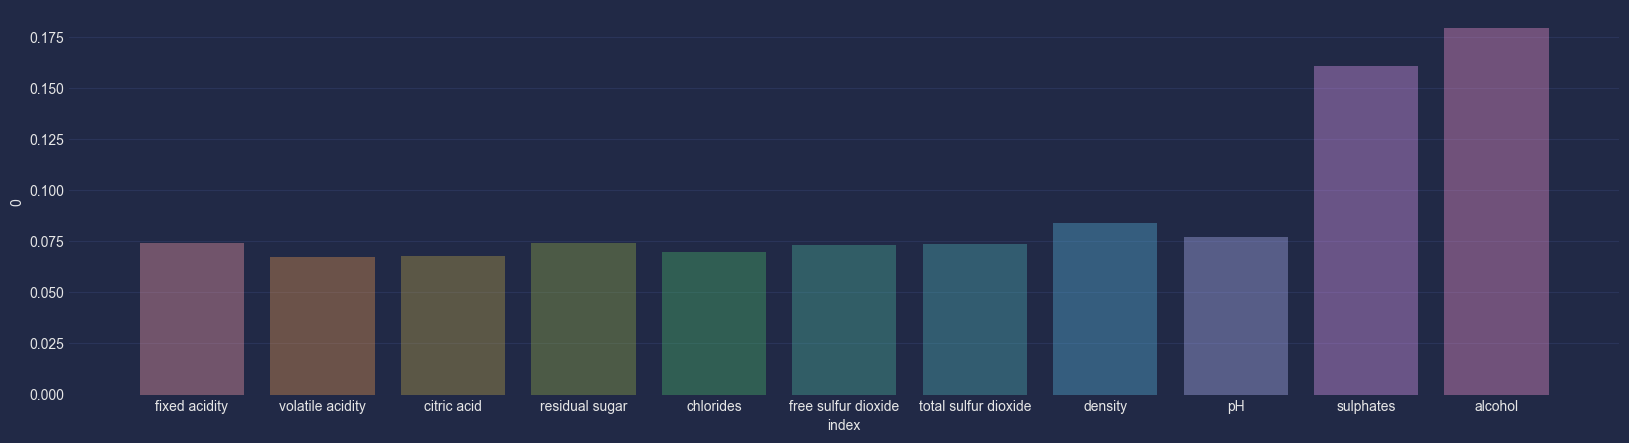

In [203]:
plt.style.use("cyberpunk")

histplot_hyperparams = {
        'alpha':0.4,
        #'stat':'percent',
        #'bins':100
        #'kde':True,
    }

n_cols = 1
n_rows = 1
cell_with_dim = 20
cell_height_dim = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
sns.barplot(fi_df.T.reset_index(), x='index', y=0,ax=ax, label=feature, **histplot_hyperparams)
#sns.histplot(train_df[target], ax=ax, **histplot_hyperparams)

mplcyberpunk.make_lines_glow(ax)
plt.show()

In [210]:
static_params = {
        'tree_method': 'gpu_hist',
        'objective':'multi:softmax',
        'seed':2016,
        'n_jobs': -1,
        'early_stopping_rounds': 100
}

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(**static_params), param_grid = param_test1, cv=5)

X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)

gsearch1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])


[0]	validation_0-mlogloss:1.53596
[1]	validation_0-mlogloss:1.39306
[2]	validation_0-mlogloss:1.30483
[3]	validation_0-mlogloss:1.24234
[4]	validation_0-mlogloss:1.19884
[5]	validation_0-mlogloss:1.16557
[6]	validation_0-mlogloss:1.13755
[7]	validation_0-mlogloss:1.11923
[8]	validation_0-mlogloss:1.10233
[9]	validation_0-mlogloss:1.09229
[10]	validation_0-mlogloss:1.08252
[11]	validation_0-mlogloss:1.07778
[12]	validation_0-mlogloss:1.07393
[13]	validation_0-mlogloss:1.06986
[14]	validation_0-mlogloss:1.06663
[15]	validation_0-mlogloss:1.06195
[16]	validation_0-mlogloss:1.06009
[17]	validation_0-mlogloss:1.06021
[18]	validation_0-mlogloss:1.06321
[19]	validation_0-mlogloss:1.06289
[20]	validation_0-mlogloss:1.06148
[21]	validation_0-mlogloss:1.05958
[22]	validation_0-mlogloss:1.06060
[23]	validation_0-mlogloss:1.06110
[24]	validation_0-mlogloss:1.06194
[25]	validation_0-mlogloss:1.06259
[26]	validation_0-mlogloss:1.06389
[27]	validation_0-mlogloss:1.06533
[28]	validation_0-mlogloss:1.0

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [213]:
predictions = gsearch1.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions)
print(score)

0.4363171228360091


In [226]:
gsearch1.best_params_

{'max_depth': 3, 'min_child_weight': 3}

In [ ]:
static_params.update(gsearch1.best_params_)

In [227]:
param_test1 = {
    'min_child_weight':[6,8,10,12]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(**static_params), param_grid = param_test1, cv=5)

gsearch1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

[0]	validation_0-mlogloss:1.53561
[1]	validation_0-mlogloss:1.39558
[2]	validation_0-mlogloss:1.31457
[3]	validation_0-mlogloss:1.25242
[4]	validation_0-mlogloss:1.21314
[5]	validation_0-mlogloss:1.17759
[6]	validation_0-mlogloss:1.14741
[7]	validation_0-mlogloss:1.13430
[8]	validation_0-mlogloss:1.12414
[9]	validation_0-mlogloss:1.10981
[10]	validation_0-mlogloss:1.09878
[11]	validation_0-mlogloss:1.09706
[12]	validation_0-mlogloss:1.09396
[13]	validation_0-mlogloss:1.09587
[14]	validation_0-mlogloss:1.09454
[15]	validation_0-mlogloss:1.09557
[16]	validation_0-mlogloss:1.09801
[17]	validation_0-mlogloss:1.09636
[18]	validation_0-mlogloss:1.09911
[19]	validation_0-mlogloss:1.10113
[20]	validation_0-mlogloss:1.10507
[21]	validation_0-mlogloss:1.10381
[22]	validation_0-mlogloss:1.10900
[23]	validation_0-mlogloss:1.10716
[24]	validation_0-mlogloss:1.10611
[25]	validation_0-mlogloss:1.11178
[26]	validation_0-mlogloss:1.11322
[27]	validation_0-mlogloss:1.11728
[28]	validation_0-mlogloss:1.1

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=100,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             param_grid={'min_child_weight': [6, 8, 10, 12]})

In [228]:
predictions = gsearch1.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions)
print(score)

0.522624653692779


In [229]:
gsearch1.best_params_


{'min_child_weight': 12}

In [230]:
static_params.update(gsearch1.best_params_)

In [231]:
param_test1 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(**static_params), param_grid = param_test1, cv=5)

gsearch1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

[0]	validation_0-mlogloss:1.53570
[1]	validation_0-mlogloss:1.39718
[2]	validation_0-mlogloss:1.31190
[3]	validation_0-mlogloss:1.24938
[4]	validation_0-mlogloss:1.20669
[5]	validation_0-mlogloss:1.17682
[6]	validation_0-mlogloss:1.15086
[7]	validation_0-mlogloss:1.13383
[8]	validation_0-mlogloss:1.11976
[9]	validation_0-mlogloss:1.10991
[10]	validation_0-mlogloss:1.09965
[11]	validation_0-mlogloss:1.09915
[12]	validation_0-mlogloss:1.10016
[13]	validation_0-mlogloss:1.09408
[14]	validation_0-mlogloss:1.09376
[15]	validation_0-mlogloss:1.09220
[16]	validation_0-mlogloss:1.09408
[17]	validation_0-mlogloss:1.09614
[18]	validation_0-mlogloss:1.09526
[19]	validation_0-mlogloss:1.09637
[20]	validation_0-mlogloss:1.09723
[21]	validation_0-mlogloss:1.10184
[22]	validation_0-mlogloss:1.10234
[23]	validation_0-mlogloss:1.10270
[24]	validation_0-mlogloss:1.10290
[25]	validation_0-mlogloss:1.10617
[26]	validation_0-mlogloss:1.10592
[27]	validation_0-mlogloss:1.10672
[28]	validation_0-mlogloss:1.1

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=100,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=12,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]})

In [232]:
predictions = gsearch1.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions)
print(score)

0.5162180194368902


In [233]:
gsearch1.best_params_

{'gamma': 0.3}

In [234]:
static_params.update(gsearch1.best_params_)

In [235]:
param_test1 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(**static_params), param_grid = param_test1, cv=5)

gsearch1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

[0]	validation_0-mlogloss:1.55465
[1]	validation_0-mlogloss:1.42101
[2]	validation_0-mlogloss:1.33850
[3]	validation_0-mlogloss:1.26796
[4]	validation_0-mlogloss:1.22228
[5]	validation_0-mlogloss:1.18494
[6]	validation_0-mlogloss:1.15761
[7]	validation_0-mlogloss:1.13476
[8]	validation_0-mlogloss:1.12477
[9]	validation_0-mlogloss:1.11470
[10]	validation_0-mlogloss:1.10919
[11]	validation_0-mlogloss:1.09455
[12]	validation_0-mlogloss:1.09425
[13]	validation_0-mlogloss:1.08789
[14]	validation_0-mlogloss:1.08508
[15]	validation_0-mlogloss:1.08204
[16]	validation_0-mlogloss:1.08243
[17]	validation_0-mlogloss:1.08161
[18]	validation_0-mlogloss:1.08014
[19]	validation_0-mlogloss:1.07766
[20]	validation_0-mlogloss:1.07907
[21]	validation_0-mlogloss:1.08028
[22]	validation_0-mlogloss:1.07828
[23]	validation_0-mlogloss:1.07527
[24]	validation_0-mlogloss:1.07892
[25]	validation_0-mlogloss:1.07895
[26]	validation_0-mlogloss:1.08209
[27]	validation_0-mlogloss:1.08222
[28]	validation_0-mlogloss:1.0

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=100,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.3, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=12,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]})

In [239]:
predictions = gsearch1.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions)
print(score)

0.5553578317161427


In [240]:
gsearch1.best_params_

{'colsample_bytree': 0.6, 'subsample': 0.8}

In [241]:
static_params.update(gsearch1.best_params_)

In [242]:
param_test1 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(**static_params), param_grid = param_test1, cv=5)

gsearch1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

[0]	validation_0-mlogloss:1.55285
[1]	validation_0-mlogloss:1.42077
[2]	validation_0-mlogloss:1.33560
[3]	validation_0-mlogloss:1.26525
[4]	validation_0-mlogloss:1.21905
[5]	validation_0-mlogloss:1.18289
[6]	validation_0-mlogloss:1.15207
[7]	validation_0-mlogloss:1.13385
[8]	validation_0-mlogloss:1.12205
[9]	validation_0-mlogloss:1.11560
[10]	validation_0-mlogloss:1.11207
[11]	validation_0-mlogloss:1.10217
[12]	validation_0-mlogloss:1.09831
[13]	validation_0-mlogloss:1.09533
[14]	validation_0-mlogloss:1.08993
[15]	validation_0-mlogloss:1.09037
[16]	validation_0-mlogloss:1.09268
[17]	validation_0-mlogloss:1.09391
[18]	validation_0-mlogloss:1.09032
[19]	validation_0-mlogloss:1.09395
[20]	validation_0-mlogloss:1.09450
[21]	validation_0-mlogloss:1.09861
[22]	validation_0-mlogloss:1.10137
[23]	validation_0-mlogloss:1.10057
[24]	validation_0-mlogloss:1.10192
[25]	validation_0-mlogloss:1.10354
[26]	validation_0-mlogloss:1.10757
[27]	validation_0-mlogloss:1.10796
[28]	validation_0-mlogloss:1.1

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6,
                                     early_stopping_rounds=100,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.3, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=12,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]})

In [243]:
predictions = gsearch1.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions)
print(score)

0.5553578317161427


In [244]:
gsearch1.best_params_

{'reg_alpha': 1e-05}

In [245]:
static_params.update(gsearch1.best_params_)

In [246]:
gsearch1.best_estimator_.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

[0]	validation_0-mlogloss:1.54978
[1]	validation_0-mlogloss:1.41751
[2]	validation_0-mlogloss:1.33084
[3]	validation_0-mlogloss:1.26309
[4]	validation_0-mlogloss:1.21533
[5]	validation_0-mlogloss:1.18051
[6]	validation_0-mlogloss:1.15890
[7]	validation_0-mlogloss:1.14077
[8]	validation_0-mlogloss:1.12237
[9]	validation_0-mlogloss:1.11385
[10]	validation_0-mlogloss:1.10985
[11]	validation_0-mlogloss:1.09687
[12]	validation_0-mlogloss:1.09667
[13]	validation_0-mlogloss:1.09169
[14]	validation_0-mlogloss:1.09037
[15]	validation_0-mlogloss:1.08580
[16]	validation_0-mlogloss:1.07984
[17]	validation_0-mlogloss:1.08061
[18]	validation_0-mlogloss:1.07840
[19]	validation_0-mlogloss:1.07933
[20]	validation_0-mlogloss:1.07769
[21]	validation_0-mlogloss:1.07936
[22]	validation_0-mlogloss:1.08346
[23]	validation_0-mlogloss:1.08547
[24]	validation_0-mlogloss:1.08406
[25]	validation_0-mlogloss:1.08006
[26]	validation_0-mlogloss:1.07817
[27]	validation_0-mlogloss:1.07586
[28]	validation_0-mlogloss:1.0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=100,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=12, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

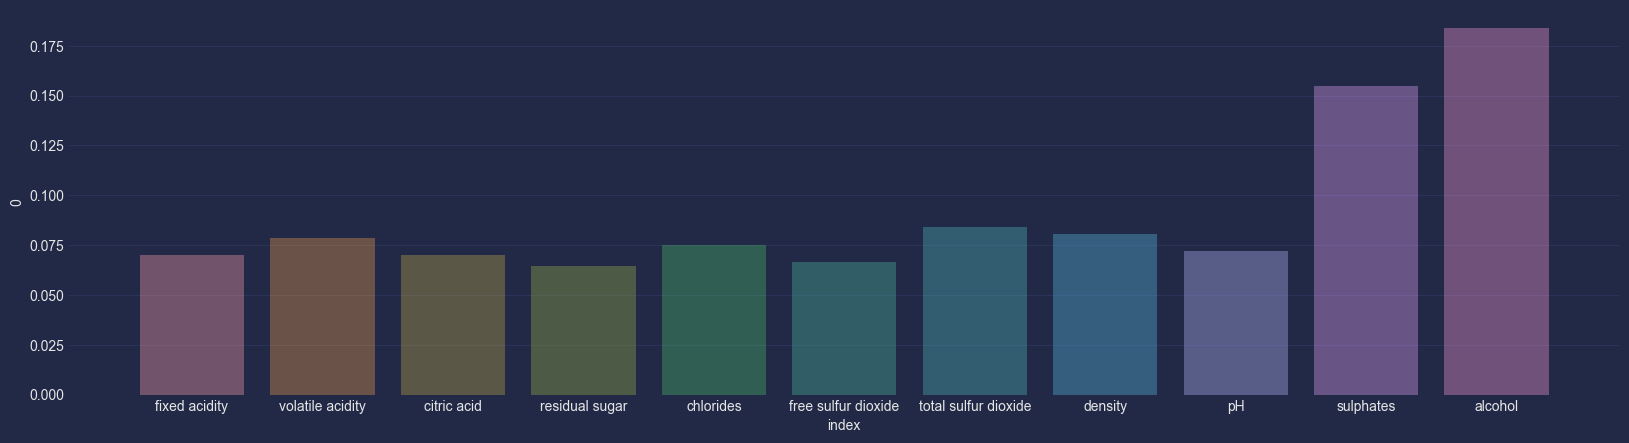

In [247]:
plt.style.use("cyberpunk")

histplot_hyperparams = {
        'alpha':0.4,
        #'stat':'percent',
        #'bins':100
        #'kde':True,
    }

n_cols = 1
n_rows = 1
cell_with_dim = 20
cell_height_dim = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

fi_df = pd.DataFrame([gsearch1.best_estimator_.feature_importances_], columns=train_df[features].columns)
sns.barplot(fi_df.T.reset_index(), x='index', y=0,ax=ax, label=feature, **histplot_hyperparams)
#sns.histplot(train_df[target], ax=ax, **histplot_hyperparams)

mplcyberpunk.make_lines_glow(ax)
plt.show()

In [248]:
train_final_preds = gsearch1.best_estimator_.predict(train_df[features])+3
test_final_preds = gsearch1.best_estimator_.predict(test_df[features])+3

In [249]:
train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)

test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)

In [ ]:
param_test1 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(**static_params), param_grid = param_test1, cv=5)

gsearch1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

In [219]:
gsearch1.best_estimator_.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

[0]	validation_0-mlogloss:1.53695
[1]	validation_0-mlogloss:1.39540
[2]	validation_0-mlogloss:1.30668
[3]	validation_0-mlogloss:1.24080
[4]	validation_0-mlogloss:1.19759
[5]	validation_0-mlogloss:1.16297
[6]	validation_0-mlogloss:1.13780
[7]	validation_0-mlogloss:1.12233
[8]	validation_0-mlogloss:1.10609
[9]	validation_0-mlogloss:1.09619
[10]	validation_0-mlogloss:1.08562
[11]	validation_0-mlogloss:1.07982
[12]	validation_0-mlogloss:1.07549
[13]	validation_0-mlogloss:1.07308
[14]	validation_0-mlogloss:1.06748
[15]	validation_0-mlogloss:1.06324
[16]	validation_0-mlogloss:1.06086
[17]	validation_0-mlogloss:1.06089
[18]	validation_0-mlogloss:1.06243
[19]	validation_0-mlogloss:1.06311
[20]	validation_0-mlogloss:1.06376
[21]	validation_0-mlogloss:1.06514
[22]	validation_0-mlogloss:1.06331
[23]	validation_0-mlogloss:1.06290
[24]	validation_0-mlogloss:1.06528
[25]	validation_0-mlogloss:1.06919
[26]	validation_0-mlogloss:1.07292
[27]	validation_0-mlogloss:1.07257
[28]	validation_0-mlogloss:1.0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

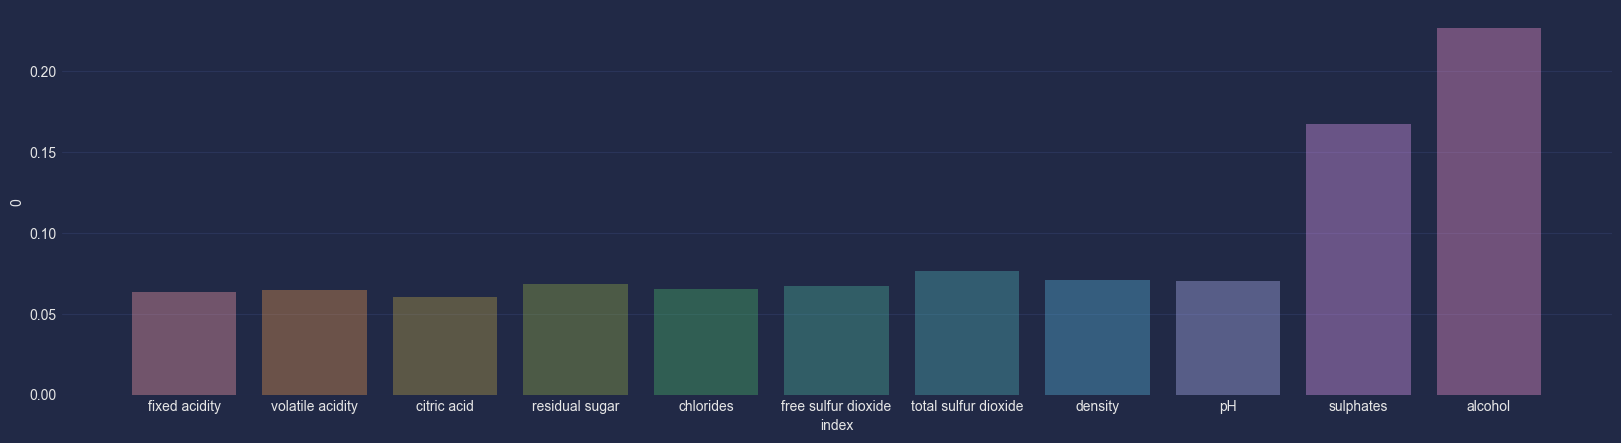

In [220]:
plt.style.use("cyberpunk")

histplot_hyperparams = {
        'alpha':0.4,
        #'stat':'percent',
        #'bins':100
        #'kde':True,
    }

n_cols = 1
n_rows = 1
cell_with_dim = 20
cell_height_dim = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

fi_df = pd.DataFrame([gsearch1.best_estimator_.feature_importances_], columns=train_df[features].columns)
sns.barplot(fi_df.T.reset_index(), x='index', y=0,ax=ax, label=feature, **histplot_hyperparams)
#sns.histplot(train_df[target], ax=ax, **histplot_hyperparams)

mplcyberpunk.make_lines_glow(ax)
plt.show()

In [221]:
train_final_preds = gsearch1.best_estimator_.predict(train_df[features])+3
test_final_preds = gsearch1.best_estimator_.predict(test_df[features])+3

In [222]:
test_final_preds

array([5, 6, 5, ..., 5, 5, 5])

In [116]:
parm_grid_bytes = pickle.dumps(param_grid_history)
with open(f"rendered_data/{objective}_bytes.hex", "wb") as binary_file:
    binary_file.write(parm_grid_bytes)

In [117]:
def train(param_grid):
    model = gsearch1.best_estimator_
    X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    predictions = model.predict(train_df[features])
    score = cohen_kappa_score(train_df[target], predictions)
    print(score)
    return model

percent = math.ceil(len(param_grid_history.keys()) * .1)
top = sorted(list(param_grid_history.keys()))[-1:]

train_preds = []
test_preds = []
for key in tqdm(top):
    train_preds.append(gsearch1.best_estimator_.predict(train_df[features])+3)
    test_preds.append(gsearch1.best_estimator_.predict(test_df[features])+3)

train_final_preds = np.stack(train_preds).mean(0).astype(int)
test_final_preds = np.stack(test_preds).mean(0).astype(int)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.99s/it]

0.32619506461524606


In [118]:
test_final_preds

array([5, 6, 5, ..., 5, 5, 5])

In [119]:
train_df[f'xgb_{target[0]}'] = train_final_preds

In [120]:
model.feature_importances_.shape

(11,)

In [121]:
train_df[features].columns.shape

(11,)

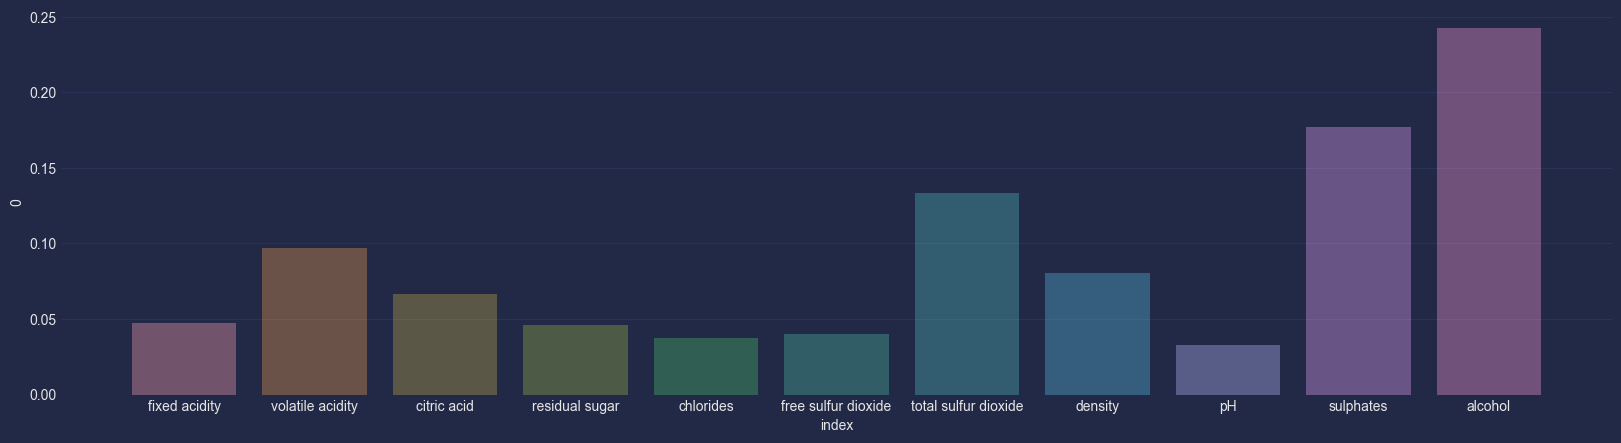

In [148]:
plt.style.use("cyberpunk")

histplot_hyperparams = {
        'alpha':0.4,
        #'stat':'percent',
        #'bins':100
        #'kde':True,
    }

n_cols = 1
n_rows = 1
cell_with_dim = 20
cell_height_dim = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
sns.barplot(fi_df.T.reset_index(), x='index', y=0,ax=ax, label=feature, **histplot_hyperparams)
#sns.histplot(train_df[target], ax=ax, **histplot_hyperparams)

mplcyberpunk.make_lines_glow(ax)
plt.show()

In [140]:
fi_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.047504,0.096856,0.066439,0.045913,0.037451,0.039832,0.133444,0.080506,0.032787,0.176705,0.242562


In [132]:
fi_df.T

,0
fixed acidity,0.047504
volatile acidity,0.096856
citric acid,0.066439
residual sugar,0.045913
chlorides,0.037451
free sulfur dioxide,0.039832
total sulfur dioxide,0.133444
density,0.080506
pH,0.032787
sulphates,0.176705


0
1
2
3
4
5
6
7
8
9
10


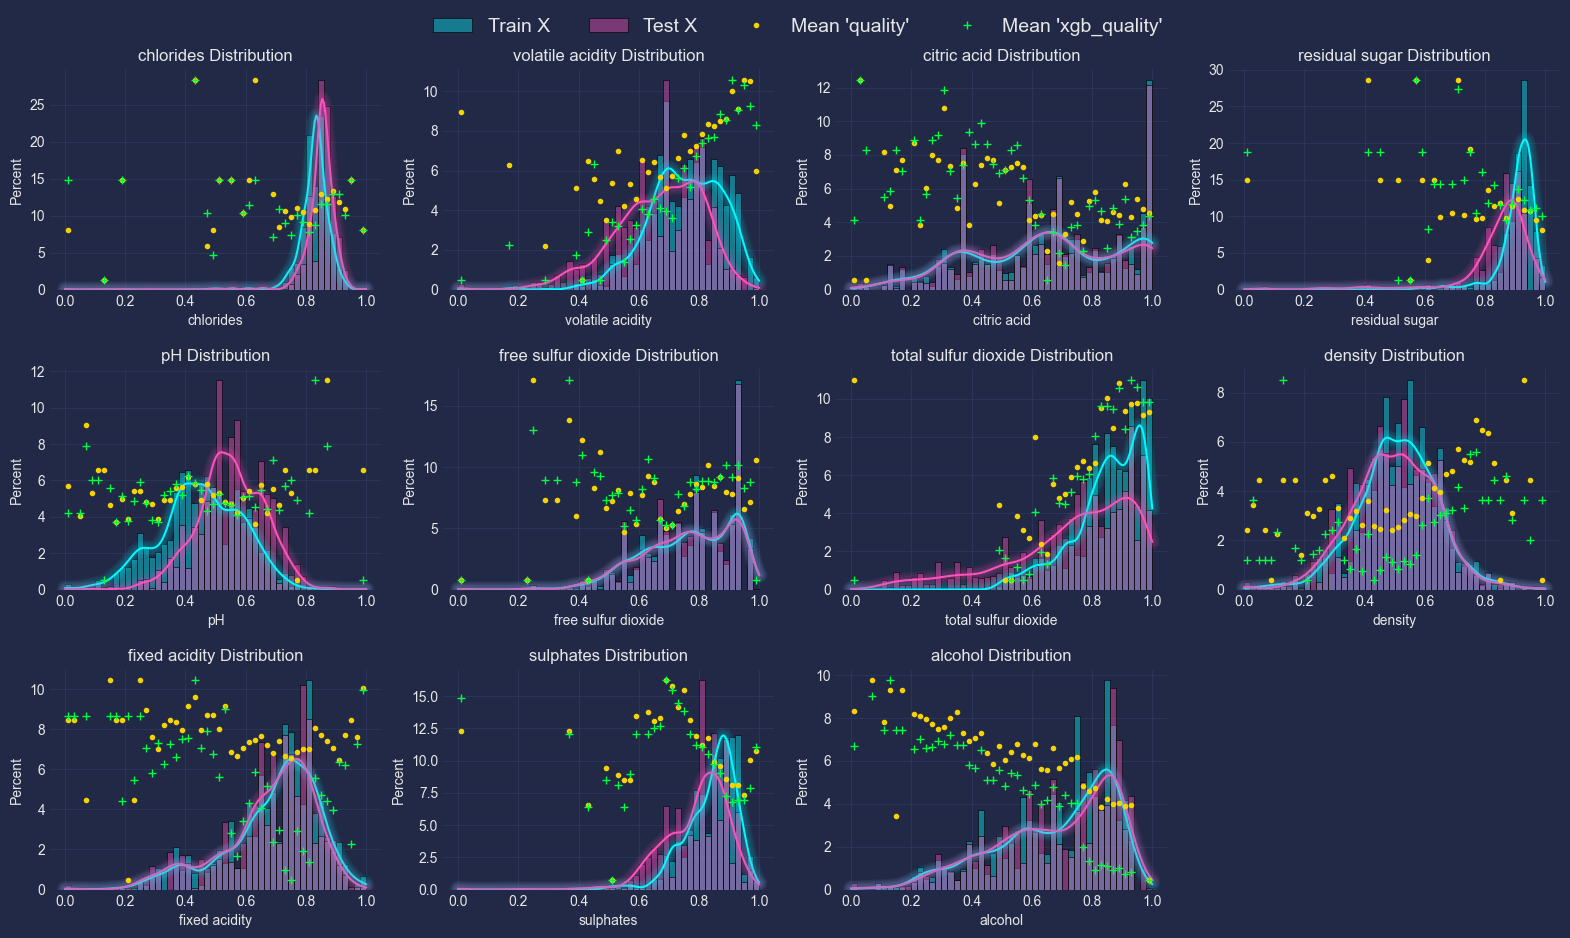

In [223]:
train_df[f'xgb_{target[0]}'] = train_final_preds
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0], f'xgb_{target[0]}'])

In [224]:
train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)

test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)